# MODELING TRAFFIC-DENSTIY OF THE CITY OF VIENNA
<i> Part 2: Constrained Optimization</i>
***

In this project I attempt to model the traffic-density for the City of Vienna solely based on publicly available data.<br><br>
<b>Data Sources:</b> 
- <u>Road network:</u> The official road network from (https://www.data.gv.at/) consists of information on ~30000 street segments and its respective geolocation and street-type.
- <u>Uber rides:</u> Information on Uber rides per City can be accessed at (https://movement.uber.com/). Uber is splitting the City of Vienna into 1370 subdistricts where travel-time between these starting & ending-areas is reported. Additional categorical information about weekdays or time of the day are available.

<b>Approach:</b><br><br>
<u>Part 1: Simulating Paths</u>
<ul>
    <li>Initialize a network graph consisting of all recorded streets of the City of Vienna</li>
    <li>Map maximum speed-limit to each network edge dependent on its street-type</li>
    <li>Calculate the shortest path of streets between pairs of start/end-nodes in the network</li>
    <li>Collect shortest path information for every start/end combination observed in the set of Uber rides</li>
</ul>

<u>Part 2: Constrained Optimization</u>
<ul>
    <li>Frame a constrained optimiziation problem to derive a "traffic-coefficient" per each area, representing its traffic-density</li>
    <li>Analyze traffic-density per area during different times of the day</li>

<img src="img/cover.jpg" alt="Drawing" style="width: 800px;"/><br>

<center>
    Photo by <a href="https://unsplash.com/@ahmgeek?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Ahmad Tolba</a> on <a href="https://unsplash.com/s/photos/vienna-cars?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
   </center>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Imports-&amp;-Settings" data-toc-modified-id="1-Imports-&amp;-Settings-1">1 Imports &amp; Settings</a></span></li><li><span><a href="#2-Data" data-toc-modified-id="2-Data-2">2 Data</a></span><ul class="toc-item"><li><span><a href="#2.1-Paths" data-toc-modified-id="2.1-Paths-2.1">2.1 Paths</a></span></li><li><span><a href="#2.2-Areas" data-toc-modified-id="2.2-Areas-2.2">2.2 Areas</a></span></li><li><span><a href="#2.3-Coefficients" data-toc-modified-id="2.3-Coefficients-2.3">2.3 Coefficients</a></span></li></ul></li><li><span><a href="#3-Optimization" data-toc-modified-id="3-Optimization-3">3 Optimization</a></span></li><li><span><a href="#4-Model-Evaluation" data-toc-modified-id="4-Model-Evaluation-4">4 Model Evaluation</a></span></li><li><span><a href="#5-Visuals" data-toc-modified-id="5-Visuals-5">5 Visuals</a></span><ul class="toc-item"><li><span><a href="#5.1-Coefficients" data-toc-modified-id="5.1-Coefficients-5.1">5.1 Coefficients</a></span></li><li><span><a href="#5.2-Traffic-Density" data-toc-modified-id="5.2-Traffic-Density-5.2">5.2 Traffic Density</a></span></li><li><span><a href="#5.3-Traffic-Speed" data-toc-modified-id="5.3-Traffic-Speed-5.3">5.3 Traffic Speed</a></span></li></ul></li><li><span><a href="#6-Scenario-Analysis" data-toc-modified-id="6-Scenario-Analysis-6">6 Scenario Analysis</a></span><ul class="toc-item"><li><span><a href="#6.1-Load-Coefficients" data-toc-modified-id="6.1-Load-Coefficients-6.1">6.1 Load Coefficients</a></span></li><li><span><a href="#6.2-Distribution-of-Coefficients" data-toc-modified-id="6.2-Distribution-of-Coefficients-6.2">6.2 Distribution of Coefficients</a></span></li><li><span><a href="#6.3-Comparison-by-Area" data-toc-modified-id="6.3-Comparison-by-Area-6.3">6.3 Comparison by Area</a></span></li></ul></li></ul></div>

### 1 Imports & Settings
***

In [1]:
# Library for data handliing
import numpy as np
import pandas as pd
import time

# Library for networkx analysis
import networkx as nx

# Library to split data into train & test set
from sklearn.model_selection import train_test_split

# Library for constrained optimization
from scipy.optimize import minimize

# Libraries for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for gemoetry & animation
from matplotlib.patches import Polygon
from matplotlib.cm import ScalarMappable
from matplotlib.animation import FuncAnimation
from shapely.geometry import Polygon as Centroid

In [2]:
# Custom library
import data_areas
import street_network

### 2 Data
***

#### 2.1 Paths

In [3]:
n_coefs = 1370
idx_num = list(np.arange(1,n_coefs+1).astype("str"))
idx_str = [(lambda x: x.zfill(4))(x) for x in idx_num]

In [4]:
# Load paths data
paths = pd.read_csv("output/paths.csv", sep=",", index_col="Unnamed: 0")
paths.head()

,sourceid,dstid,month,mean_travel_time,standard_deviation_travel_time,time_of_day,weekday,weeknum,weekend,1,...,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370
0,317,1267,2,270.67,142.65,16-19,4,8,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1126,638,2,220.74,114.06,19-0,4,8,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,954,422,2,223.30,208.47,10-16,2,7,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,915,928,3,104.00,30.76,0-7,2,13,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,954,422,3,163.63,103.31,10-16,0,10,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Scenario name
scenario = "all"

# Apply filters for scenario
# paths = paths[paths["time_of_day"]=="16-19"]

In [6]:
# Splitting between independent matrix and dependent vector 
X = paths[idx_num].astype(float)
y = paths["mean_travel_time"]

# Train & test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Number of observations in train & test set
n_train = len(X_train)
n_test  = len(X_test)

#### 2.2 Areas

In [7]:
# List of areas not passed by any path in the train set
empty_areas = np.sum(X_train, axis=0)
empty_areas = empty_areas[empty_areas==0].index
empty_areas

Index(['6', '49', '63', '85', '104', '118', '126', '132', '163', '168', '169',
       '173', '192', '204', '212', '219', '221', '256', '261', '267', '271',
       '280', '295', '296', '303', '306', '310', '312', '321', '324', '333',
       '346', '349', '397', '433', '454', '461', '519', '521', '534', '571',
       '580', '593', '595', '597', '606', '614', '643', '703', '714', '728',
       '750', '753', '778', '784', '795', '846', '850', '858', '875', '882',
       '895', '897', '904', '920', '990', '1008', '1052', '1074', '1075',
       '1077', '1087', '1098', '1106', '1131', '1133', '1167', '1171', '1223',
       '1236', '1262', '1309', '1313', '1314', '1318', '1352', '1365', '1366',
       '1368', '1369', '1370'],
      dtype='object')

In [8]:
# List of areas outside of Vienna
outer_areas = ["1365","1366","1367","1368","1369","1370"]

#### 2.3 Coefficients

In [9]:
# Load the initial starting points for coefs
try:
    coefs_init = pd.read_csv("output/0coefs.csv", sep=",", squeeze=True, index_col="Unnamed: 0")
    print("Coefficients are imported!\n")
    print(coefs_init.tail())
    
except IOError:
    coefs_init = np.random.normal(loc=0.20, scale=0.04, size=n_coefs)
    print("Coefficients are initialized as normally distributed around 0.20!")

Coefficients are initialized as normally distributed around 0.20!


### 3 Optimization
***

In [10]:
def loss_func(coefs, **kwargs):
    """
    A function that returns the residual squared error, based on a set of coefs
    
    Parameters
    ----------
    coefs : pd.Series
    test : bool (optional)
    """
    
    if "test" in kwargs:
        if kwargs["test"] is True:
            X, y, n = X_test, y_test, n_test
        
    else:
        X, y, n = X_train, y_train, n_train
    
    est  = np.dot(X,coefs)
    err  = np.sum(np.power(est-y,2))
    rmse = np.sqrt(err/n)
    return rmse


def callback_func(coefs_i):
    """A function that prints runtime at each iteration"""
    
    global start_time, coefs_list, iteration
    
    iteration += 1

    # Track results at each iteration
    rmse = loss_func(coefs_i)
    rmse_list.append(rmse)
    coefs_list.append(pd.Series(coefs_i))
    
    run_time = (time.time() - start_time)/60
    print (f"Iter: {str(iteration)} has {rmse:.4f} RMSE after {run_time:.2f} minutes")

In [11]:
# Boundaries for coefficients
bounds = [(0.03,0.72)] * n_coefs

# Store results at each iteration in list
rmse_list  = [loss_func(coefs_init)]
coefs_list = [coefs_init]

# Counter for iterations
iteration = 0

In [12]:
# Run optimization
start_time = time.time()

result = minimize(
    fun=loss_func, 
    x0=coefs_init,
    bounds=bounds,
    callback=callback_func)

Iter: 1 has 325.1287 RMSE after 1.81 minutes
Iter: 2 has 182.5682 RMSE after 2.68 minutes
Iter: 3 has 155.0427 RMSE after 3.60 minutes
Iter: 4 has 146.3195 RMSE after 4.45 minutes
Iter: 5 has 140.6149 RMSE after 5.59 minutes
Iter: 6 has 137.7445 RMSE after 6.50 minutes
Iter: 7 has 135.8686 RMSE after 7.36 minutes
Iter: 8 has 134.5904 RMSE after 8.23 minutes
Iter: 9 has 133.4880 RMSE after 9.15 minutes
Iter: 10 has 132.5691 RMSE after 10.49 minutes


In [13]:
# Output results
coefs = pd.Series(data=result.x, index=idx_str, name="coefs")
n_it  = result.nit
rmse  = result.fun

print (f"RMSE: {rmse:.4f}")

RMSE: 132.5691


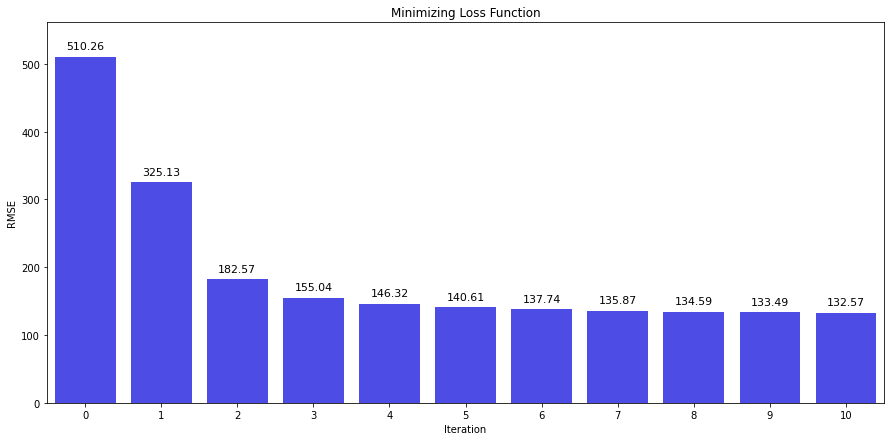

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))

sns.barplot(x=np.arange(n_it+1), y=rmse_list, color="blue", alpha=0.8, orient="v", ax=ax)

# Formatting
ax.set_ylim(0,rmse_list[0]*1.1)
ax.set_xlabel("Iteration", fontsize=10)
ax.set_ylabel("RMSE", fontsize=10)
ax.set_title("Minimizing Loss Function")

# Annotations
for p in ax.patches:
    x_val = p.get_x()
    y_val = p.get_height()
    bar   = p.get_width()/2

    ax.annotate(text = str(round(y_val,2)), 
                xy = (x_val+bar, y_val+rmse_list[0]*0.03), 
                ha = "center", 
                va = "center",
                fontsize = 11)

plt.savefig("img/loss-"+scenario+".png")
plt.show()

In [15]:
coefs.to_csv("output/coefs-"+scenario+".csv")

### 4 Model Evaluation
***

In [16]:
rmse_test = loss_func(coefs=coefs, test=True)
rmse_test

133.89277489081752

In [17]:
sqerr = (rmse_test**2)*n_test
naive = np.sum((y_test-np.mean(y_test))**2)
rrse  = np.sqrt(sqerr/naive)
rrse

0.5599669593435331

### 5 Visuals
***

#### 5.1 Coefficients

In [47]:
%matplotlib notebook

In [48]:
Colors = street_network.NetworkColors()
cpal = Colors.get_cpal(11)
cpal

C:\Users\bernh\Jupyter scripts\02 Projects New\Vienna\street_network.py:302: UserWarning: Trying to register the cmap 'vienna-roads' which already exists.
  register_cmap("vienna-roads", self.cmap)


[(0.8391695501730103, 0.8228373702422145, 0.4374625144175319),
 (0.6783391003460209, 0.8260668973471741, 0.4749250288350635),
 (0.509850057670127, 0.8294502114571318, 0.5141714725105729),
 (0.34901960784313757, 0.8326797385620914, 0.5516339869281047),
 (0.18818915801614766, 0.8359092656670513, 0.5890965013456364),
 (0.027112648981161058, 0.8370165321030373, 0.6266974240676665),
 (0.17760861207227996, 0.7446520569011919, 0.5950480584390619),
 (0.32810457516339864, 0.6522875816993464, 0.5633986928104575),
 (0.48576701268742783, 0.5555247981545559, 0.530242214532872),
 (0.6362629757785467, 0.46316032295271037, 0.49859284890426736),
 (0.7867589388696654, 0.37079584775086527, 0.4669434832756633)]

In [49]:
def update_hist(i):
    # Clearing plot
    plt.cla()
    
    # Formatting plot
    ax.set_xlim(0, 0.4)
    ax.set_ylim(0, 25)
    ax.set_title("Iteration: "+str(i), fontsize=9)
    
    # Formatting labels
    ax.set_xlabel("Coefficient values", fontsize=8)
    ax.set_ylabel("Density", fontsize=8)
    ax.tick_params(axis="both", which="major", labelsize=8) 
    
    # Updating plot with new data
    sns.kdeplot(coefs_list[i], fill=True, color=cpal[i], bw_adjust=0.5, ax=ax)

<IPython.core.display.Javascript object>


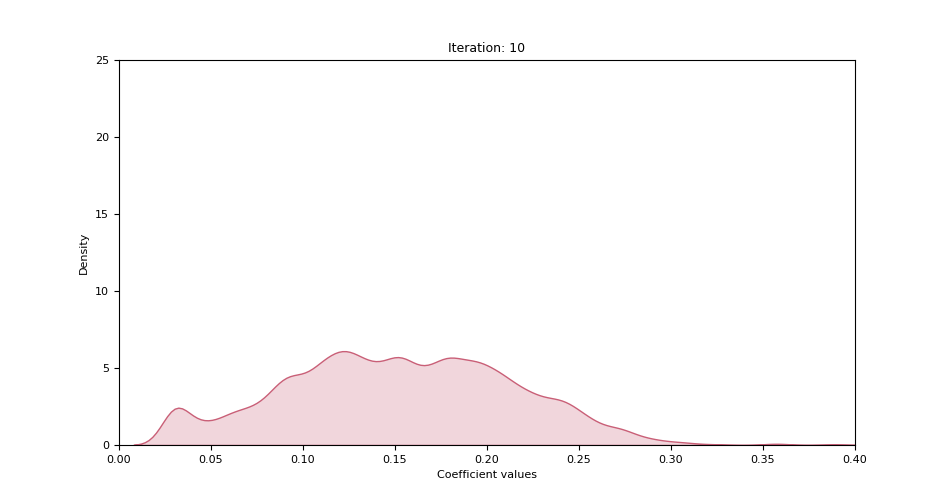

In [50]:
# Initialize static figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9.5,5))

sns.kdeplot(coefs_list[0], fill=True, color=cpal[0], bw_adjust=0.5, ax=ax)

# Animation
animation = FuncAnimation(
    fig=fig, 
    func=update_hist, 
    frames=len(coefs_list),
    interval=400,
    repeat=False)

plt.show()

In [22]:
animation.save("img/coefs-distribution-"+scenario+".gif", writer="Pillow")


MovieWriter Pillow unavailable; using Pillow instead.


In [51]:
%matplotlib inline

#### 5.2 Traffic Density

In [24]:
# Instantiate network graph
Vienna = nx.Graph()

In [25]:
# Call areas class and execute its functions
Areas = data_areas.Areas()
Areas.load_data(filename="vienna_statistical_areas.json")
Areas.load_graph(graph=Vienna)

In [41]:
# Get colormap
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=np.min(coefs), vmax=np.max(coefs)*0.8)

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

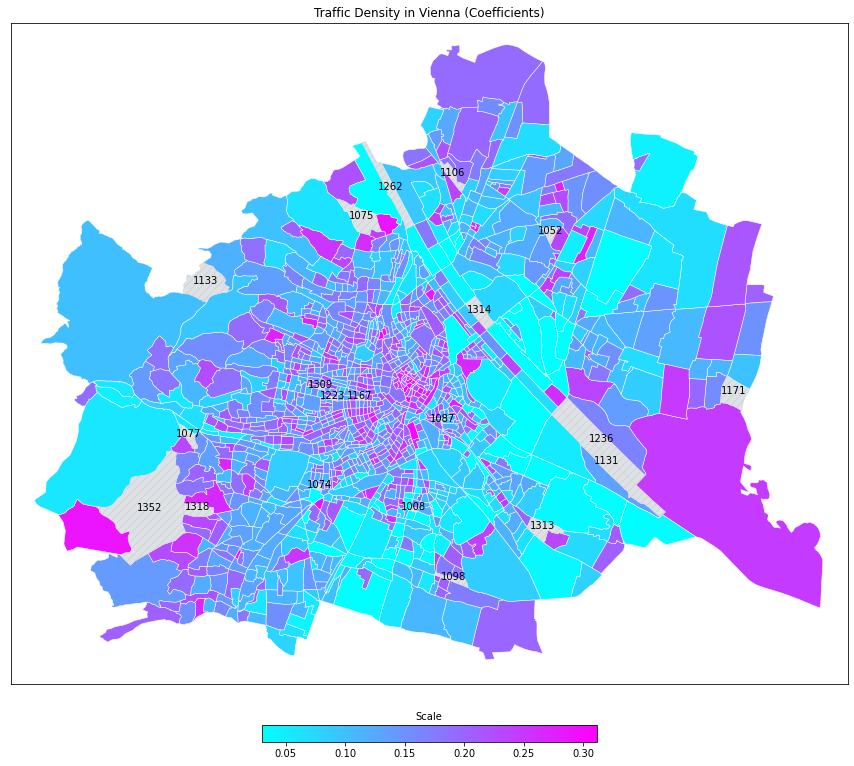

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15.2))

# Set axis limits for figure
ax.set_xlim(16.17, 16.59)
ax.set_ylim(48.11, 48.33)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Traffic Density in Vienna (Coefficients)", fontsize=12)

for key,val in Areas.polygons.items():
    
    idx = int(key)-1
    density = norm(coefs[idx])
    
    # Skipping plotting for outer areas
    if key in outer_areas:
        continue
    
    # Plot areas with density data
    elif key not in empty_areas:
        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor=cmap(density), 
            edgecolor="white",
            linewidth=0.5))
    
    # Plot areas without density data
    elif key in empty_areas:
        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor="#dee2e6", 
            edgecolor="lightgray",
            hatch=r"///",
            linewidth=0.5))
        
        x_center, y_center = Centroid(val).centroid.coords[0]
        ax.text(x=x_center, y=y_center, s=key, ha="center")

# Add colormap
cbar = fig.colorbar(
    mappable=sm,
    orientation="horizontal",
    shrink=0.4, 
    pad=0.05,
    ax=ax)

cbar.ax.set_title("Scale", fontsize=10)
plt.savefig("img/coefs-map-"+scenario+".png")
plt.show()

#### 5.3 Traffic Speed

In [43]:
def coef_kmh(coefs):
    """
    A function that converts coefficients from s/m into km/h
    
    Parameters
    ----------
    coefs : np.array
    """
    mps = 1/coefs
    kmh = mps/1000*3600
    
    return kmh

In [44]:
kmh = coef_kmh(coefs=coefs)
kmh

0001     27.562982
0002     17.206783
0003    120.000000
0004     32.839274
0005     17.044941
           ...    
1366     13.168155
1367     31.571908
1368     14.866894
1369     14.771320
1370     15.827960
Name: coefs, Length: 1370, dtype: float64

In [45]:
# Get colormap
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=np.min(kmh), vmax=np.max(kmh)*0.9)

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

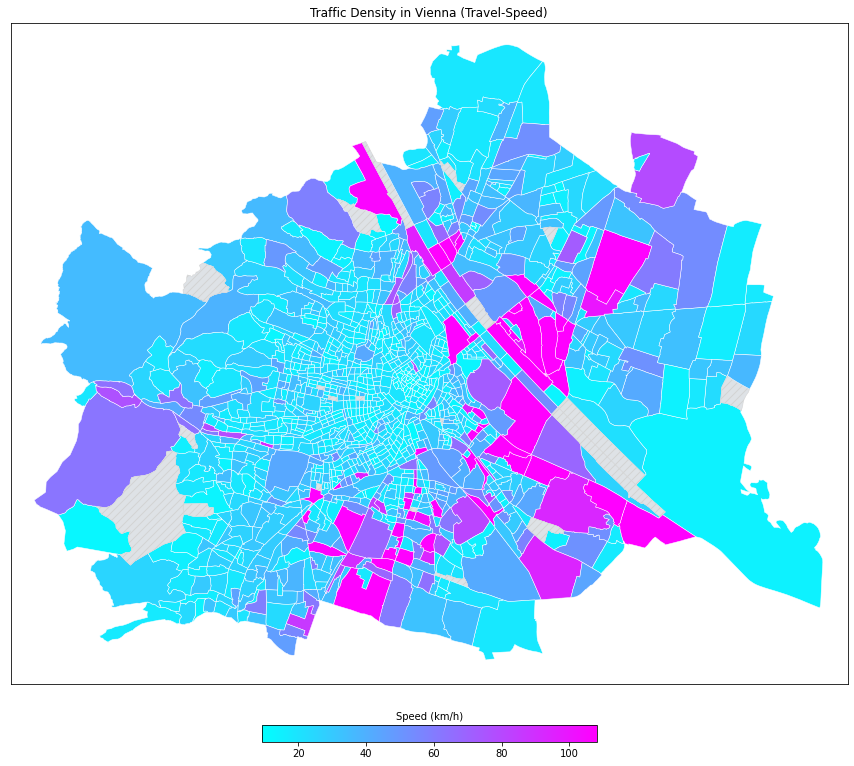

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15.2))

# Set axis limits for figure
ax.set_xlim(16.17, 16.59)
ax.set_ylim(48.11, 48.33)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Traffic Density in Vienna (Travel-Speed)", fontsize=12)

for key,val in Areas.polygons.items():
    
    idx = int(key)-1
    density = norm(kmh[idx])
    
    # Skipping plotting for outer areas
    if key in outer_areas:
        continue
    
    # Plot areas with density data
    elif key not in empty_areas:
        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor=cmap(density), 
            edgecolor="white",
            linewidth=0.5))
    
    # Plot areas without density data
    elif key in empty_areas:
        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor="#dee2e6", 
            edgecolor="lightgray",
            hatch=r"///",
            linewidth=0.5))


# Add colormap
cbar = fig.colorbar(
    mappable=sm,
    orientation="horizontal",
    shrink=0.4, 
    pad=0.05,
    ax=ax)

cbar.ax.set_title("Speed (km/h)", fontsize=10)
plt.savefig("img/speed-map-"+scenario+".png")
plt.show()

### 6 Scenario Analysis
***

#### 6.1 Load Coefficients

In [32]:
coefs_all   = pd.read_csv("output/coefs-all.csv", index_col="Unnamed: 0", squeeze=True)
coefs_early = pd.read_csv("output/coefs-morning.csv", index_col="Unnamed: 0", squeeze=True)
coefs_late  = pd.read_csv("output/coefs-afternoon.csv", index_col="Unnamed: 0", squeeze=True)

kmh_all   = coef_kmh(coefs=coefs_all)
kmh_early = coef_kmh(coefs=coefs_early)
kmh_late  = coef_kmh(coefs=coefs_late)

#### 6.2 Distribution of Coefficients

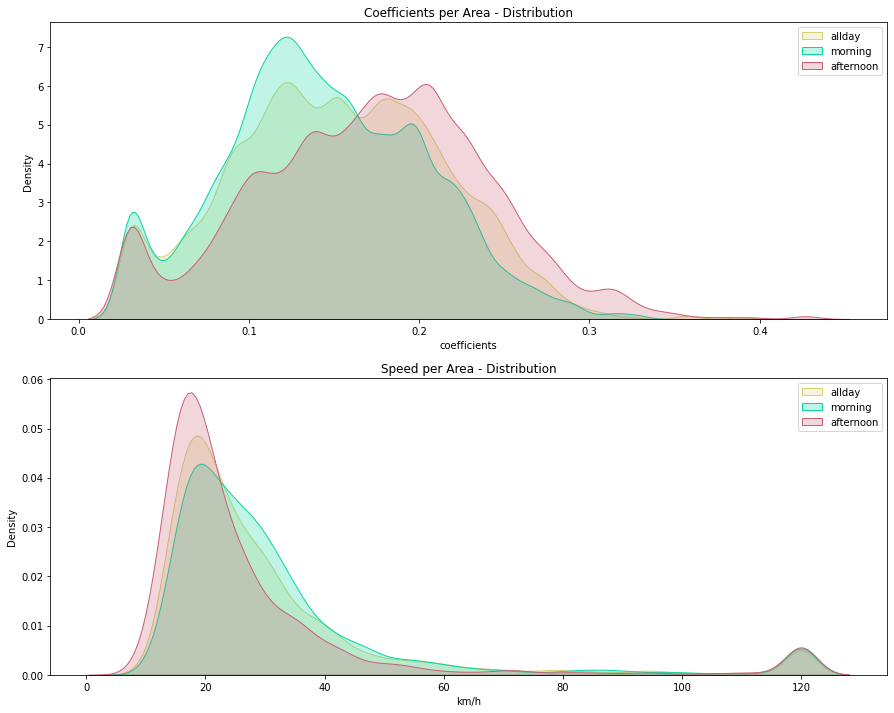

In [52]:
# Initialize static figure
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,12))

# Axis #1
sns.kdeplot(coefs_all,   fill=True, color=cpal[0], bw_adjust=0.5, label="allday", ax=ax[0])
sns.kdeplot(coefs_early, fill=True, color=cpal[5], bw_adjust=0.5, label="morning", ax=ax[0])
sns.kdeplot(coefs_late,  fill=True, color=cpal[10], bw_adjust=0.5, label="afternoon", ax=ax[0])

# Axis #2
sns.kdeplot(kmh_all,   fill=True, color=cpal[0], bw_adjust=0.5, label="allday", ax=ax[1])
sns.kdeplot(kmh_early, fill=True, color=cpal[5], bw_adjust=0.5, label="morning", ax=ax[1])
sns.kdeplot(kmh_late,  fill=True, color=cpal[10], bw_adjust=0.5, label="afternoon", ax=ax[1])


ax[0].set_title("Coefficients per Area - Distribution")
ax[0].set_xlabel("coefficients")

ax[1].set_title("Speed per Area - Distribution")
ax[1].set_xlabel("km/h")

ax[0].legend()
ax[1].legend()

plt.savefig("img/coefs-distribution-scenarios.png")
plt.show()

#### 6.3 Comparison by Area

In [34]:
# Array of delta between each coefficient in morning vs. afternoon trafic
coefs_diff = coefs_late-coefs_early

In [35]:
# Get colormap
cmap = mpl.cm.bwr
norm = mpl.colors.Normalize(vmin=np.min(coefs_diff), vmax=np.max(coefs_diff))

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

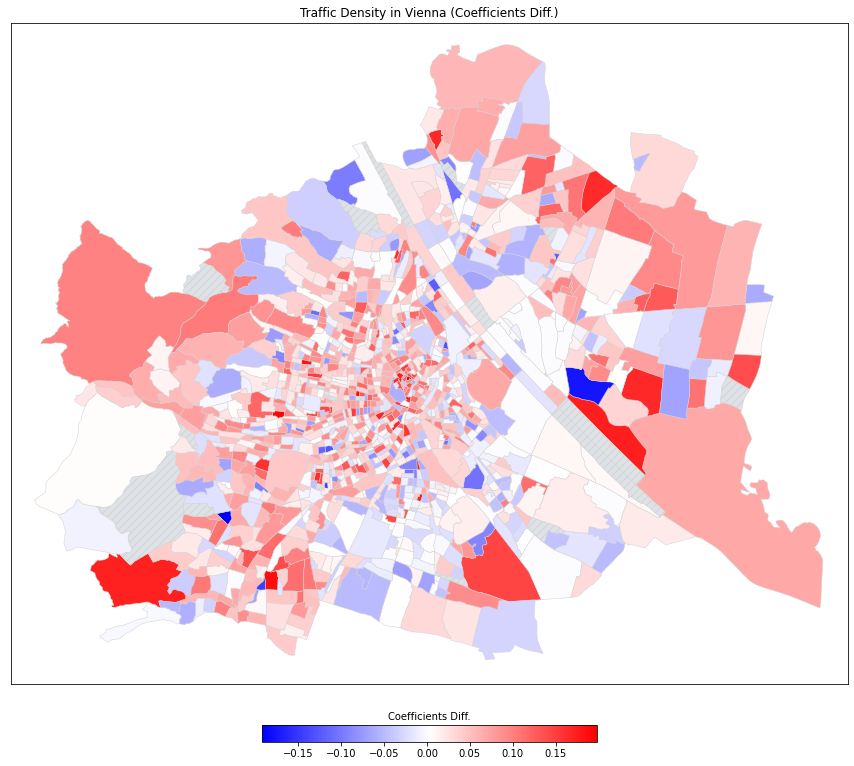

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15.2))

# Set axis limits for figure
ax.set_xlim(16.17, 16.59)
ax.set_ylim(48.11, 48.33)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Traffic Density in Vienna (Coefficients Diff.)", fontsize=12)

for key,val in Areas.polygons.items():
    
    idx = int(key)
    density = norm(coefs_diff[idx])
    
    # Skipping plotting for outer areas
    if key in outer_areas:
        continue
    
    # Plot areas with density data
    elif key not in empty_areas:
        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor=cmap(density), 
            edgecolor="lightgray",
            linewidth=0.5))
    
    # Plot areas without density data
    elif key in empty_areas:
        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor="#dee2e6", 
            edgecolor="lightgray",
            hatch=r"///",
            linewidth=0.5))
        

# Add colormap
cbar = fig.colorbar(
    mappable=sm,
    orientation="horizontal",
    shrink=0.4, 
    pad=0.05,
    ax=ax)

cbar.ax.set_title("Coefficients Diff.", fontsize=10)
plt.savefig("img/coefs-map-diff.png")
plt.show()